In [1]:
import matplotlib.pyplot as plt
from biom import Table, load_table
from biom.util import biom_open
from functools import partial
from skbio import TreeNode
import numpy as np
import pandas as pd
from unifrac import faith_pd
from tempfile import NamedTemporaryFile
import multiprocessing
import itertools
from itertools import repeat
import json
import matplotlib
import seaborn as sns
N_WORKERS = multiprocessing.cpu_count()

In [2]:
table_MG_path = 'data/finrisk/anonymized-finrisk-MG-BL_AGE-filtered_rarefied_table.biom'
finrisk_metadata_path = 'data/finrisk/anonymized.age-only.finrisk.metadata.txt'
wol_tree_path = 'data/wol/wol-tree.nwk'

In [3]:
table_MG = load_table(table_MG_path)
metadata = pd.read_csv(finrisk_metadata_path, sep='\t', low_memory=False, index_col=0)

In [4]:
class FaithPDAnalysis:
    
    def __init__(self, table_path, tree_path, metadata):
        self.table_path = table_path
        self.tree_path = tree_path
        self.metadata = metadata
        self.faith_pd = None
        
    def convert_table(self):
        pass
        
    def convert_tree(self):
        pass
        
    def get_faith_pd(self):
        self.convert_table()
        self.convert_tree()
        table_biom_path = self.table_path
        tree_path = self.tree_path
        faith_series = pd.DataFrame(faith_pd(table_biom_path, tree_path))
        faith_series.index.name = '#SampleID'
        self.faith_pd = faith_series
        return faith_series
    
    def get_observed_otus(self):
        table = load_table(self.table_path)
        observed_otus = pd.DataFrame((table.matrix_data > 0).sum(axis=0)).transpose()
        observed_otus.index = table.ids('sample')
        observed_otus.index.name = '#SampleID'
        observed_otus.columns = ['observed_otus']
        self.observed_otus = observed_otus
        return observed_otus
    
    def merge_metadata(self):
        faith_pd = self.get_faith_pd()
        observed_otus = self.get_observed_otus()
        self.metadata = faith_pd.join(observed_otus).join(self.metadata)
        return self.metadata
    
    def filter_metadata(self, fn):
        self.metadata = self.metadata.loc[fn(self.metadata)]
        return self.metadata
    
    def boolean_splitter(self, fn, metadata=None):
        if metadata is None:
            metadata = self.metadata
        bools = fn(metadata)
        return metadata[bools], metadata[~bools]
    
    def make_splitter(self, fn):
        def f(metadata):
            bools = fn(metadata)
            return metadata[bools], metadata[~bools]
        return f

In [5]:
fpd_MG = FaithPDAnalysis(table_MG_path, wol_tree_path, metadata)
fpd_MG.merge_metadata()

TARGET = 'BL_AGE'

age_filter = lambda x: (x[TARGET] >= 60) | (x[TARGET] <= 35)
dataset_MG = fpd_MG.filter_metadata(age_filter)

def age_splitter(x): return x.loc[(x[TARGET] >= 60)], x.loc[(x[TARGET] <= 35)]

partial_splitter = fpd_MG.make_splitter(age_splitter)

datasets = {
    'MG': dataset_MG
}

In [6]:
age_cat = np.where(datasets['MG']['BL_AGE'] < 50, 'Young (<=35)', 'Old (>60)')

In [7]:
datasets['MG']['age_cat'] = age_cat

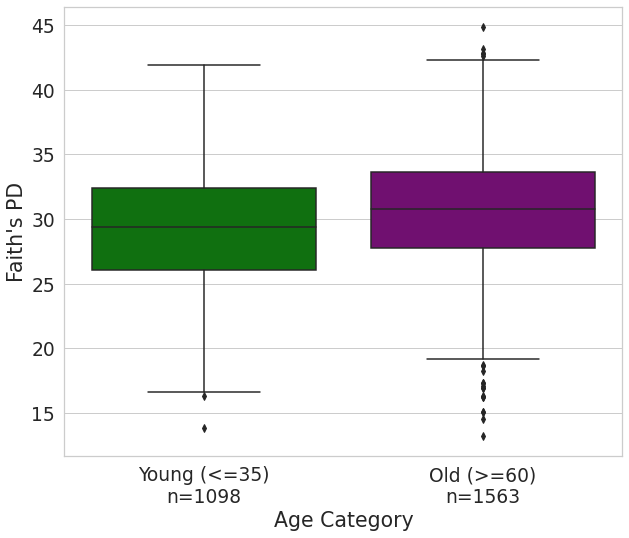

In [8]:
sns.set_theme(
    font_scale=1.7,
    rc={'figure.figsize':(10,8.27)}
)
sns.set_style("whitegrid")

ax = sns.boxplot(
    x='age_cat',
    y='faith_pd',
    data=datasets['MG'].sort_values(by='age_cat', ascending=False),
    palette=[
        '#008000',
        '#800080',

    ],
    hue_order=[
        'Young',
        'Old',
    ]
)

ax.set_xticklabels(['Young (<=35)\nn=1098', 'Old (>=60)\nn=1563'])
ax.set_ylabel('Faith\'s PD')
ax.set_xlabel('Age Category')
plt.savefig('results/03.01-alpha-distributions-young-old.png')
plt.show()